<small><i>Using code from the Notebook Machine Learning II of [Oriol Pujol Vila](http://www.maia.ub.es/~oriol)</i></small>

# SVM Food vs. Non-food

Clasificador Food - Non-food a través d'una SVM amb kernel sigmoidea amb paràmetre $\gamma = 10^{-5}$. 

Hem reescalat totes les imatges a $100x100$ i emprat HOG com a extractor de característiques.

Base de dades per entrenar: 
http://iplab.dmi.unict.it/madima2015/

In [1]:
#util and imports
%matplotlib inline

import os
import fnmatch
from cStringIO import StringIO
import numpy as np
import PIL.Image
import IPython.display
import shutil
import matplotlib.pyplot as plt
import numpy as np
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import metrics
from skimage import io
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
import cv2

In [2]:
def list_all_files(directory, extensions=None):
    for root, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            base, ext = os.path.splitext(filename)
            joined = os.path.join(root, filename)
            if extensions is None or ext.lower() in extensions:
                yield joined

In [3]:
food = list(list_all_files('./UNICT-FlickrFood/', ['.jpg']))
#food = [i.replace(".jpg","") for i in list_all_files('./UNICT-FD889/', ['.jpg'])]
print 'loaded', len(food), "food"
nonfood = list(list_all_files('./UNICT-FlickrNon-Food/', ['.jpg']))
print 'loaded', len(nonfood), "non-food"
examples = [(path, 0) for path in food]+[(path, 1) for path in nonfood]

loaded 8387 food
loaded 8005 non-food


In [12]:
import cv2
from skimage.measure import block_reduce
from skimage.io import imread
from skimage.feature import hog

def examples_to_dataset(examples, block_size=2):
    X = []
    y = []
    number = 0
    sum_img_mean = 0
    size = 200
    for path, label in examples:  
        #reescalem les imatges fins deixar-les 100x100 pixels
        img = imread(path, as_grey=True)
        rows = img.shape[0]
        cols = img.shape[1]
        center = np.array([rows/2, cols/2])     

        if (rows>cols):
            crop_size = cols/2
            img = img[center[0]-crop_size:center[0]+crop_size,:]
        else : 
            crop_size = rows/2 
            img = img[:,center[1]-crop_size:center[1]+crop_size]

        img = transform.resize(img, (size,size))  
        img = block_reduce(img, block_size=(2, 2), func=np.mean)
        
        #extractor de caracteristiques hog del skimage
        hog = hog(img, orientations=8, pixels_per_cell=(10, 10),
                cells_per_block=(1, 1), visualise=False)
        X.append(hog)
        if(label==0):
            y.append(0)
        else:
            y.append(1)
    return np.asarray(X), np.asarray(y)

In [13]:
%time X, Y = examples_to_dataset(examples)
X = np.asarray(X,dtype=np.float32)
Y = np.asarray(Y,dtype=np.int32)

CPU times: user 4min 20s, sys: 9.84 s, total: 4min 30s
Wall time: 4min 34s


In [14]:
X.shape

/Users/GBG141/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:90: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/GBG141/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:667: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


(16392, 800)

In [15]:
#NO SNOOPING
import numpy as np
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import metrics

kf=cross_validation.KFold(n=Y.shape[0], n_folds=5,  shuffle=True)

acc = np.zeros((5,))
i=0
#We will build the predicted y from the partial predictions on the test of each of the folds
yhat = Y.copy()
for train_index, test_index in kf:
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    #Standard parameters
    clf = svm.SVC(kernel='sigmoid', gamma = 0.00001, C = 1)
    clf.fit(X_train,Y_train.ravel())
    X_test = scaler.transform(X_test)
    yhat[test_index] = clf.predict(X_test)
    acc[i] = metrics.accuracy_score(yhat[test_index], Y_test)
    print acc[i]
    i=i+1
print 'Mean accuracy: '+ str(np.mean(acc))

0.815187557182
0.813357731016
0.817876754118
0.828248932276
0.825198291641
Mean accuracy: 0.819973853247


/Users/GBG141/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


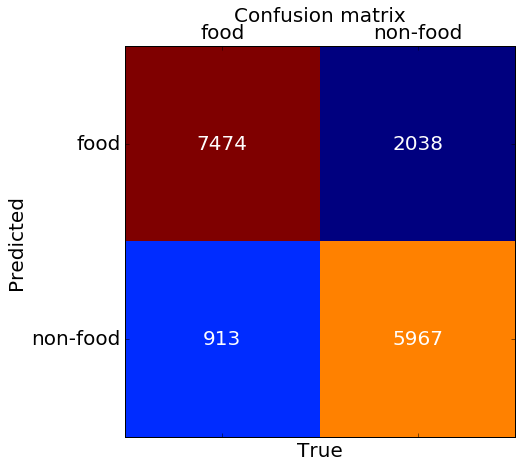

             precision    recall  f1-score   support

          0       0.79      0.89      0.84      8387
          1       0.87      0.75      0.80      8005

avg / total       0.83      0.82      0.82     16392



In [17]:
import matplotlib.pyplot as plt
def draw_confusion(y,yhat,labels):
    cm = metrics.confusion_matrix(y, yhat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(cm)
    plt.title('Confusion matrix',size=20)
    ax.set_xticklabels([''] + labels, size=20)
    ax.set_yticklabels([''] + labels, size=20)
    plt.ylabel('Predicted',size=20)
    plt.xlabel('True',size=20)
    for i in xrange(2):
        for j in xrange(2):
            ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
    fig.set_size_inches(7,7)
    plt.show()

draw_confusion(Y,yhat,['food', 'non-food'])
print metrics.classification_report(Y,yhat)